# FIKH Model: Creep Response

## Protocol-Specific Context

**Creep** (constant stress) reveals **delayed yielding** and **viscosity bifurcation** in FIKH:

1. **Below yield stress**: Initial elastic deformation + slow structural breakdown
2. **Intermediate stress**: Delayed avalanche-like yielding with delay time $t_d \sim \tau_{thix} \left(\frac{\sigma_y(1) - \sigma_0}{\sigma_0}\right)^{1/\alpha}$
3. **Above yield stress**: Immediate plastic flow + potential thermal runaway

**Why this matters**: The $1/\alpha$ exponent means **smaller $\alpha$ gives exponentially longer delays** for the same stress ratio. This is a hallmark of strong memory — the material resists yielding because it "remembers" its structured state.

> **Physical insight**: Fractional memory slows structural breakdown. With $\alpha = 0.5$, a 10% stress deficit below yield can produce 100× longer delay than classical IKH ($\alpha=1$).

> **Handbook:** See [FIKH Creep Protocol](../../docs/source/models/fikh/fikh.rst#creep-step-stress) for delay time scaling and viscosity bifurcation.

## Learning Objectives

1. Predict FIKH creep curves for stresses below/above yield
2. Measure delay time $t_d$ and verify $t_d \sim (\Delta\sigma)^{-1/\alpha}$ scaling
3. Compare $\alpha = 0.5$ vs $\alpha = 0.9$ delay times
4. Observe viscosity bifurcation: delay → sudden yielding
5. Fit creep data to constrain $\alpha$ from transient dynamics

## Prerequisites

- NB01: Flow curve (yield stress parameters)
- NB03: Relaxation (fractional kinetics basics)

**Estimated Time:** 3-5 minutes (fast), 12-18 minutes (full)

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

# Robust path resolution for execution from any directory
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FIKH

_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    compute_fit_quality,
    get_fikh_param_names,
    load_ml_ikh_creep,
    plot_alpha_sweep,
    print_alpha_interpretation,
    print_convergence_summary,
    print_parameter_comparison,
    save_fikh_results,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

# FAST_MODE: controlled by environment variable
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

jax, jnp = safe_import_jax()
verify_float64()

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: Fractional Creep

Creep response under constant applied stress reveals **delayed yielding** and **viscosity bifurcation**.

### Creep Regimes

1. **Elastic response** ($t \ll \tau$): $\gamma \approx \sigma/G$
2. **Delayed yielding**: Strain accelerates as structure breaks down
3. **Steady flow** ($t \gg \tau$): $\dot{\gamma} \to \dot{\gamma}_{ss}$

### Alpha Effect on Creep

- **Lower alpha**: Slower approach to yielding, stretched acceleration
- **Higher alpha**: Sharper yield transition (classical behavior)

## 3. Load Data

In [3]:
# Load creep data from ML-IKH Excel
STRESS_PAIR = 0  # First stress jump (3 Pa → 5 Pa)
time_data, gamma_dot_data, sigma_init, sigma_final = load_ml_ikh_creep(stress_pair_index=STRESS_PAIR)

print(f"Data points: {len(time_data)}")
print(f"Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"Shear rate range: [{gamma_dot_data.min():.4g}, {gamma_dot_data.max():.4g}] 1/s")
print(f"Stress jump: {sigma_init} Pa → {sigma_final} Pa")

Data points: 70
Time range: [0.0098, 295.66] s
Shear rate range: [3.222, 6.264] 1/s
Stress jump: 3.0 Pa → 5.0 Pa


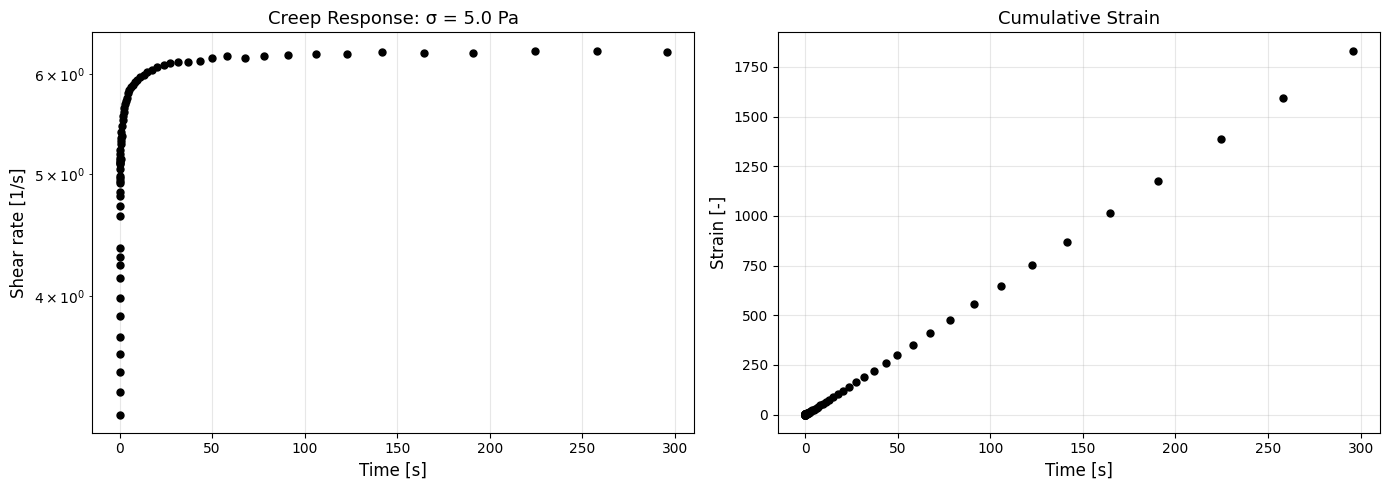

In [4]:
# Compute strain from shear rate (cumulative integration)
strain_data = np.cumsum(gamma_dot_data[:-1] * np.diff(time_data))
strain_data = np.insert(strain_data, 0, 0.0)

# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.semilogy(time_data, gamma_dot_data, "ko", markersize=5)
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Shear rate [1/s]", fontsize=12)
ax1.set_title(f"Creep Response: σ = {sigma_final} Pa", fontsize=13)
ax1.grid(True, alpha=0.3)

ax2.plot(time_data, strain_data, "ko", markersize=5)
ax2.set_xlabel("Time [s]", fontsize=12)
ax2.set_ylabel("Strain [-]", fontsize=12)
ax2.set_title("Cumulative Strain", fontsize=13)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create and fit FIKH model
model = FIKH(include_thermal=False, alpha_structure=0.7)

t0 = time.time()
model.fit(time_data, strain_data, test_mode="creep", sigma_applied=sigma_final, method='scipy')
t_nlsq = time.time() - t0

param_names = get_fikh_param_names(include_thermal=False)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

NLSQ fit time: 32.67 s

Fitted parameters:
  G               = 1000
  eta             = 0.8115
  C               = 500
  gamma_dyn       = 1
  m               = 1
  sigma_y0        = 10
  delta_sigma_y   = 50
  tau_thix        = 1
  Gamma           = 0.5
  alpha_structure = 0.7
  eta_inf         = 0.1
  mu_p            = 0.001



Fit Quality:
  R^2:   0.999908
  RMSE:  3.745


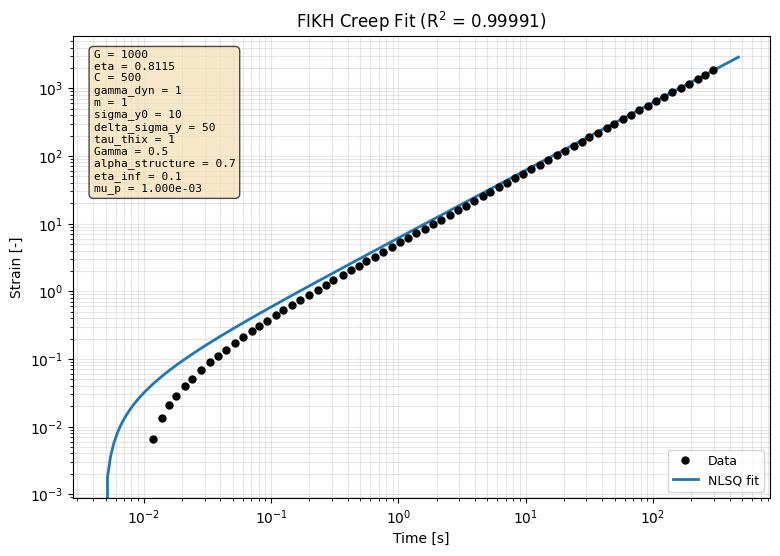

In [6]:
# Compute fit quality and plot with uncertainty band
strain_pred = model.predict(time_data, test_mode="creep", sigma_applied=sigma_final)
metrics = compute_fit_quality(strain_data, strain_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g}")

fig, ax = plot_nlsq_fit(
    time_data, strain_data, model, test_mode="creep",
    param_names=param_names, log_scale=True,
    xlabel="Time [s]", ylabel="Strain [-]",
    title=f"FIKH Creep Fit (R$^2$ = {metrics['R2']:.5f})",
    sigma_applied=sigma_final,
)
display(fig)
plt.close(fig)

## 5. Alpha Exploration

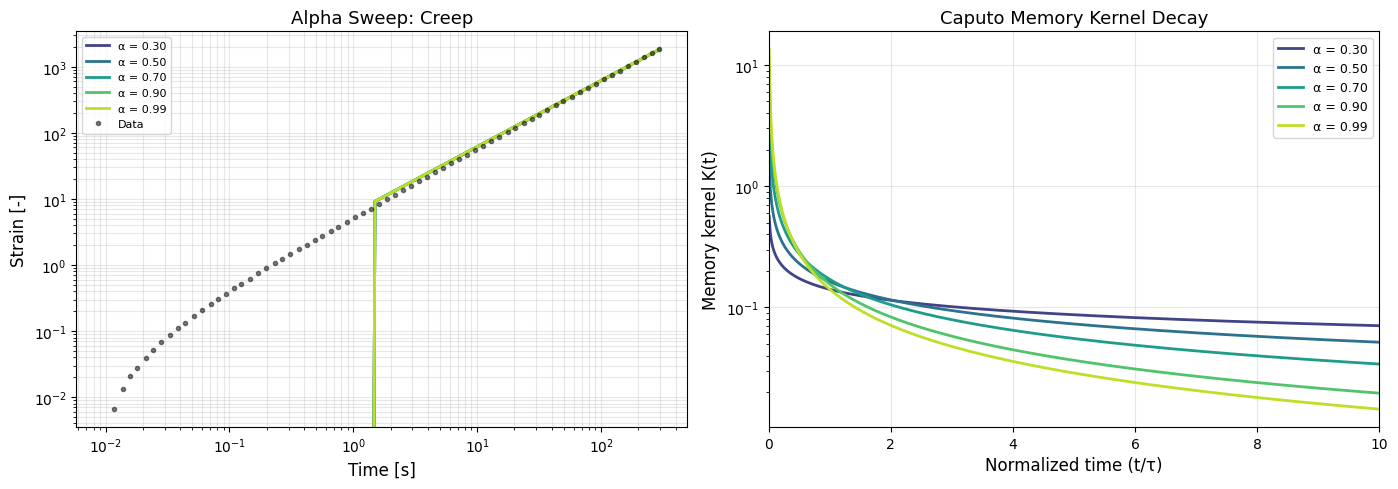

In [7]:
# Define fine time grid for alpha sweep
time_fine = np.linspace(time_data.min(), time_data.max(), 200)

# Alpha sweep for creep
alpha_values = [0.3, 0.5, 0.7, 0.9, 0.99]

fig = plot_alpha_sweep(
    model,
    protocol="creep",
    alpha_values=alpha_values,
    x_data=time_fine,
    sigma_applied=sigma_final,
    figsize=(14, 5),
)

fig.axes[0].plot(time_data, strain_data, "ko", markersize=3, alpha=0.5, label="Data")
fig.axes[0].legend(fontsize=8, loc="best")

display(fig)
plt.close(fig)

In [8]:
# Physical interpretation
fitted_alpha = model.parameters.get_value("alpha_structure")
print_alpha_interpretation(fitted_alpha)

Fractional Order Interpretation: α = 0.700

Regime: Weak Memory

Approaching classical behavior with mild power-law tails.
Recovery is mostly exponential with slow corrections.
Suitable for: Mildly thixotropic materials.

Physical Implications:
  • Memory kernel decay: t^(-0.70)
  • Recovery time scale: > τ_thix × Γ(1+0.70) = 0.91 × τ_thix
  • Relaxation modulus: Power-law with exponent ≈ -0.70


## 6. Bayesian Inference

In [9]:
# Bayesian inference
initial_values = {name: model.parameters.get_value(name) for name in param_names}

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    time_data,
    strain_data,
    test_mode="creep",
    sigma_applied=sigma_final,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:03<45:41,  3.92s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   2%|▏         | 13/700 [00:04<02:34,  4.44it/s, 80 steps of size 2.87e-03. acc. prob=0.70]

warmup:   3%|▎         | 20/700 [00:04<01:38,  6.90it/s, 255 steps of size 3.12e-04. acc. prob=0.73]

warmup:   4%|▎         | 25/700 [00:04<01:18,  8.60it/s, 255 steps of size 1.64e-03. acc. prob=0.78]

warmup:   4%|▍         | 29/700 [00:04<01:07,  9.95it/s, 255 steps of size 8.87e-04. acc. prob=0.78]

warmup:   5%|▍         | 32/700 [00:04<01:00, 11.02it/s, 255 steps of size 1.56e-03. acc. prob=0.80]

warmup:   5%|▌         | 35/700 [00:05<00:52, 12.56it/s, 255 steps of size 3.14e-04. acc. prob=0.79]

warmup:   5%|▌         | 38/700 [00:05<00:48, 13.76it/s, 255 steps of size 7.89e-04. acc. prob=0.80]

warmup:   6%|▌         | 41/700 [00:05<00:44, 14.89it/s, 255 steps of size 5.59e-04. acc. prob=0.80]

warmup:   6%|▋         | 44/700 [00:05<00:41, 15.79it/s, 255 steps of size 1.35e-03. acc. prob=0.82]

warmup:   7%|▋         | 47/700 [00:05<00:39, 16.59it/s, 255 steps of size 1.16e-03. acc. prob=0.82]

warmup:   7%|▋         | 50/700 [00:05<00:37, 17.25it/s, 255 steps of size 1.98e-03. acc. prob=0.83]

warmup:   7%|▋         | 52/700 [00:06<00:36, 17.64it/s, 255 steps of size 3.44e-04. acc. prob=0.82]

warmup:   8%|▊         | 54/700 [00:06<00:35, 18.01it/s, 255 steps of size 5.57e-04. acc. prob=0.82]

warmup:   8%|▊         | 56/700 [00:06<00:35, 18.29it/s, 255 steps of size 9.87e-04. acc. prob=0.83]

warmup:   8%|▊         | 58/700 [00:06<00:34, 18.51it/s, 255 steps of size 1.35e-03. acc. prob=0.83]

warmup:   9%|▊         | 60/700 [00:06<00:34, 18.65it/s, 255 steps of size 2.05e-03. acc. prob=0.84]

warmup:   9%|▉         | 62/700 [00:06<00:33, 18.80it/s, 255 steps of size 3.90e-04. acc. prob=0.83]

warmup:   9%|▉         | 64/700 [00:06<00:33, 18.79it/s, 255 steps of size 6.62e-04. acc. prob=0.83]

warmup:   9%|▉         | 66/700 [00:06<00:33, 18.88it/s, 255 steps of size 1.12e-03. acc. prob=0.84]

warmup:  10%|▉         | 68/700 [00:06<00:33, 18.97it/s, 255 steps of size 1.85e-03. acc. prob=0.84]

warmup:  10%|█         | 70/700 [00:06<00:33, 19.01it/s, 255 steps of size 8.49e-04. acc. prob=0.84]

warmup:  10%|█         | 72/700 [00:07<00:33, 19.02it/s, 255 steps of size 1.39e-03. acc. prob=0.84]

warmup:  11%|█         | 74/700 [00:07<00:32, 19.03it/s, 255 steps of size 1.31e-03. acc. prob=0.84]

warmup:  11%|█         | 76/700 [00:07<00:32, 19.05it/s, 255 steps of size 1.88e-03. acc. prob=0.84]

warmup:  11%|█         | 78/700 [00:07<00:32, 19.07it/s, 255 steps of size 1.08e-03. acc. prob=0.84]

warmup:  11%|█▏        | 80/700 [00:07<00:32, 19.03it/s, 255 steps of size 1.02e-03. acc. prob=0.84]

warmup:  12%|█▏        | 82/700 [00:07<00:32, 19.04it/s, 255 steps of size 1.55e-03. acc. prob=0.85]

warmup:  12%|█▏        | 84/700 [00:07<00:32, 19.01it/s, 255 steps of size 5.53e-04. acc. prob=0.84]

warmup:  12%|█▏        | 86/700 [00:07<00:32, 19.08it/s, 255 steps of size 7.24e-04. acc. prob=0.84]

warmup:  13%|█▎        | 88/700 [00:07<00:32, 19.12it/s, 255 steps of size 1.12e-03. acc. prob=0.85]

warmup:  13%|█▎        | 90/700 [00:08<00:31, 19.10it/s, 255 steps of size 1.51e-03. acc. prob=0.85]

warmup:  13%|█▎        | 92/700 [00:08<00:31, 19.15it/s, 255 steps of size 1.07e-03. acc. prob=0.85]

warmup:  13%|█▎        | 94/700 [00:08<00:31, 19.16it/s, 255 steps of size 1.59e-03. acc. prob=0.85]

warmup:  14%|█▎        | 96/700 [00:08<00:31, 19.18it/s, 255 steps of size 8.97e-04. acc. prob=0.85]

warmup:  14%|█▍        | 98/700 [00:08<00:31, 19.19it/s, 255 steps of size 9.48e-04. acc. prob=0.85]

warmup:  14%|█▍        | 100/700 [00:08<00:31, 19.17it/s, 255 steps of size 1.25e-03. acc. prob=0.85]

warmup:  15%|█▍        | 102/700 [00:08<00:31, 19.09it/s, 255 steps of size 1.99e-02. acc. prob=0.85]

warmup:  15%|█▍        | 104/700 [00:08<00:31, 19.14it/s, 255 steps of size 3.62e-02. acc. prob=0.86]

warmup:  15%|█▌        | 106/700 [00:08<00:31, 19.16it/s, 255 steps of size 6.80e-02. acc. prob=0.86]

warmup:  15%|█▌        | 108/700 [00:08<00:30, 19.16it/s, 255 steps of size 7.24e-02. acc. prob=0.86]

warmup:  16%|█▌        | 110/700 [00:09<00:30, 19.14it/s, 255 steps of size 4.16e-02. acc. prob=0.86]

warmup:  16%|█▌        | 112/700 [00:09<00:30, 19.19it/s, 255 steps of size 7.33e-02. acc. prob=0.86]

warmup:  16%|█▋        | 114/700 [00:09<00:30, 19.19it/s, 255 steps of size 7.35e-02. acc. prob=0.86]

warmup:  17%|█▋        | 116/700 [00:09<00:30, 19.13it/s, 255 steps of size 5.60e-02. acc. prob=0.86]

warmup:  17%|█▋        | 118/700 [00:09<00:30, 19.09it/s, 255 steps of size 9.69e-02. acc. prob=0.86]

warmup:  17%|█▋        | 120/700 [00:09<00:30, 19.08it/s, 255 steps of size 8.53e-02. acc. prob=0.86]

warmup:  17%|█▋        | 122/700 [00:09<00:30, 19.03it/s, 255 steps of size 7.55e-02. acc. prob=0.86]

warmup:  18%|█▊        | 124/700 [00:09<00:30, 19.05it/s, 255 steps of size 1.20e-01. acc. prob=0.87]

warmup:  18%|█▊        | 126/700 [00:09<00:30, 19.04it/s, 255 steps of size 3.69e-02. acc. prob=0.86]

warmup:  18%|█▊        | 128/700 [00:09<00:30, 19.06it/s, 255 steps of size 6.30e-02. acc. prob=0.87]

warmup:  19%|█▊        | 130/700 [00:10<00:29, 19.07it/s, 255 steps of size 9.93e-02. acc. prob=0.87]

warmup:  19%|█▉        | 132/700 [00:10<00:29, 19.05it/s, 255 steps of size 1.06e-01. acc. prob=0.87]

warmup:  19%|█▉        | 135/700 [00:10<00:27, 20.36it/s, 255 steps of size 1.04e-01. acc. prob=0.87]

warmup:  20%|█▉        | 138/700 [00:10<00:28, 19.96it/s, 255 steps of size 1.04e-01. acc. prob=0.87]

warmup:  20%|██        | 140/700 [00:10<00:28, 19.70it/s, 255 steps of size 1.34e-01. acc. prob=0.87]

warmup:  20%|██        | 143/700 [00:10<00:28, 19.83it/s, 255 steps of size 4.42e-02. acc. prob=0.87]

warmup:  21%|██        | 145/700 [00:10<00:28, 19.64it/s, 255 steps of size 6.98e-02. acc. prob=0.87]

warmup:  21%|██        | 147/700 [00:10<00:28, 19.49it/s, 255 steps of size 1.08e-01. acc. prob=0.87]

warmup:  21%|██▏       | 149/700 [00:11<00:28, 19.41it/s, 255 steps of size 1.02e-01. acc. prob=0.87]

warmup:  23%|██▎       | 159/700 [00:11<00:13, 41.30it/s, 15 steps of size 1.55e-01. acc. prob=0.87] 

warmup:  25%|██▌       | 175/700 [00:11<00:07, 73.95it/s, 31 steps of size 6.90e-02. acc. prob=0.87]

warmup:  27%|██▋       | 188/700 [00:11<00:05, 88.61it/s, 47 steps of size 1.17e-01. acc. prob=0.87]

sample:  29%|██▉       | 203/700 [00:11<00:04, 104.26it/s, 31 steps of size 9.68e-02. acc. prob=0.91]

sample:  31%|███▏      | 220/700 [00:11<00:03, 122.69it/s, 15 steps of size 9.68e-02. acc. prob=0.93]

sample:  34%|███▍      | 238/700 [00:11<00:03, 135.43it/s, 63 steps of size 9.68e-02. acc. prob=0.93]

sample:  37%|███▋      | 258/700 [00:11<00:02, 153.78it/s, 15 steps of size 9.68e-02. acc. prob=0.93]

sample:  39%|███▉      | 275/700 [00:11<00:02, 154.57it/s, 63 steps of size 9.68e-02. acc. prob=0.94]

sample:  42%|████▏     | 291/700 [00:12<00:02, 145.40it/s, 31 steps of size 9.68e-02. acc. prob=0.94]

sample:  44%|████▎     | 306/700 [00:12<00:02, 143.66it/s, 47 steps of size 9.68e-02. acc. prob=0.94]

sample:  46%|████▌     | 322/700 [00:12<00:02, 142.88it/s, 111 steps of size 9.68e-02. acc. prob=0.94]

sample:  48%|████▊     | 337/700 [00:12<00:02, 143.06it/s, 31 steps of size 9.68e-02. acc. prob=0.94] 

sample:  50%|█████     | 352/700 [00:12<00:02, 136.95it/s, 31 steps of size 9.68e-02. acc. prob=0.94]

sample:  53%|█████▎    | 369/700 [00:12<00:02, 144.96it/s, 15 steps of size 9.68e-02. acc. prob=0.95]

sample:  55%|█████▍    | 384/700 [00:12<00:02, 140.93it/s, 15 steps of size 9.68e-02. acc. prob=0.95]

sample:  57%|█████▋    | 400/700 [00:12<00:02, 145.30it/s, 31 steps of size 9.68e-02. acc. prob=0.94]

sample:  60%|█████▉    | 419/700 [00:12<00:01, 157.27it/s, 31 steps of size 9.68e-02. acc. prob=0.94]

sample:  62%|██████▏   | 437/700 [00:12<00:01, 161.72it/s, 31 steps of size 9.68e-02. acc. prob=0.94]

sample:  65%|██████▍   | 454/700 [00:13<00:01, 156.56it/s, 31 steps of size 9.68e-02. acc. prob=0.94]

sample:  67%|██████▋   | 470/700 [00:13<00:01, 157.28it/s, 15 steps of size 9.68e-02. acc. prob=0.94]

sample:  70%|██████▉   | 487/700 [00:13<00:01, 157.67it/s, 47 steps of size 9.68e-02. acc. prob=0.94]

sample:  72%|███████▏  | 504/700 [00:13<00:01, 155.98it/s, 63 steps of size 9.68e-02. acc. prob=0.94]

sample:  74%|███████▍  | 520/700 [00:13<00:01, 148.47it/s, 15 steps of size 9.68e-02. acc. prob=0.94]

sample:  77%|███████▋  | 537/700 [00:13<00:01, 153.58it/s, 31 steps of size 9.68e-02. acc. prob=0.94]

sample:  79%|███████▉  | 553/700 [00:13<00:00, 148.71it/s, 31 steps of size 9.68e-02. acc. prob=0.94]

sample:  81%|████████▏ | 570/700 [00:13<00:00, 151.12it/s, 63 steps of size 9.68e-02. acc. prob=0.94]

sample:  84%|████████▍ | 588/700 [00:13<00:00, 157.80it/s, 63 steps of size 9.68e-02. acc. prob=0.94]

sample:  87%|████████▋ | 607/700 [00:14<00:00, 165.69it/s, 31 steps of size 9.68e-02. acc. prob=0.94]

sample:  89%|████████▉ | 624/700 [00:14<00:00, 156.08it/s, 31 steps of size 9.68e-02. acc. prob=0.94]

sample:  92%|█████████▏| 641/700 [00:14<00:00, 159.42it/s, 31 steps of size 9.68e-02. acc. prob=0.94]

sample:  94%|█████████▍| 658/700 [00:14<00:00, 158.82it/s, 31 steps of size 9.68e-02. acc. prob=0.94]

sample:  96%|█████████▋| 674/700 [00:14<00:00, 155.82it/s, 31 steps of size 9.68e-02. acc. prob=0.94]

sample:  99%|█████████▊| 690/700 [00:14<00:00, 148.84it/s, 15 steps of size 9.68e-02. acc. prob=0.94]

sample: 100%|██████████| 700/700 [00:14<00:00, 47.61it/s, 31 steps of size 9.68e-02. acc. prob=0.94] 


Bayesian inference time: 20.2 s


In [10]:
# Convergence
all_pass = print_convergence_summary(result, param_names)

print("\n### Bayesian Diagnostic Interpretation")
print("| Metric | Target | Interpretation |")
print("|--------|--------|----------------|")
print("| **R-hat** | < 1.01 | Chain convergence (< 1.05 acceptable) |")
print("| **ESS** | > 400 | Effective sample size (> 100 minimum) |")
print("| **Divergences** | < 1% | NUTS sampling quality |")
print("\nPassing diagnostics ensure reliable parameter estimates and credible intervals.")

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    0.9989       558      PASS
            eta    0.9980       446      PASS
              C    1.0010      1046      PASS
      gamma_dyn    1.0090       498      PASS
              m    1.0081       241      PASS
       sigma_y0    0.9983       903      PASS
  delta_sigma_y    1.0057       734      PASS
       tau_thix    0.9980       614      PASS
          Gamma    0.9982       390      PASS
alpha_structure    0.9987       194      PASS
        eta_inf    0.9994      1212      PASS
           mu_p    0.9982       854      PASS

Divergences: 0

All convergence criteria PASSED

### Bayesian Diagnostic Interpretation
| Metric | Target | Interpretation |
|--------|--------|----------------|
| **R-hat** | < 1.01 | Chain convergence (< 1.05 acceptable) |
| **ESS** | > 400 | Effective sample size (> 100 minimum) |
| **Divergences** | < 1% | NUTS samp

### Convergence Diagnostics

**Bayesian Diagnostic Interpretation:**

| Metric | Target | Interpretation |
|--------|--------|----------------|
| **R-hat** | < 1.01 | Chain convergence (< 1.05 acceptable) |
| **ESS** | > 400 | Effective sample size (> 100 minimum) |
| **Divergences** | < 1% | NUTS sampling quality |

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


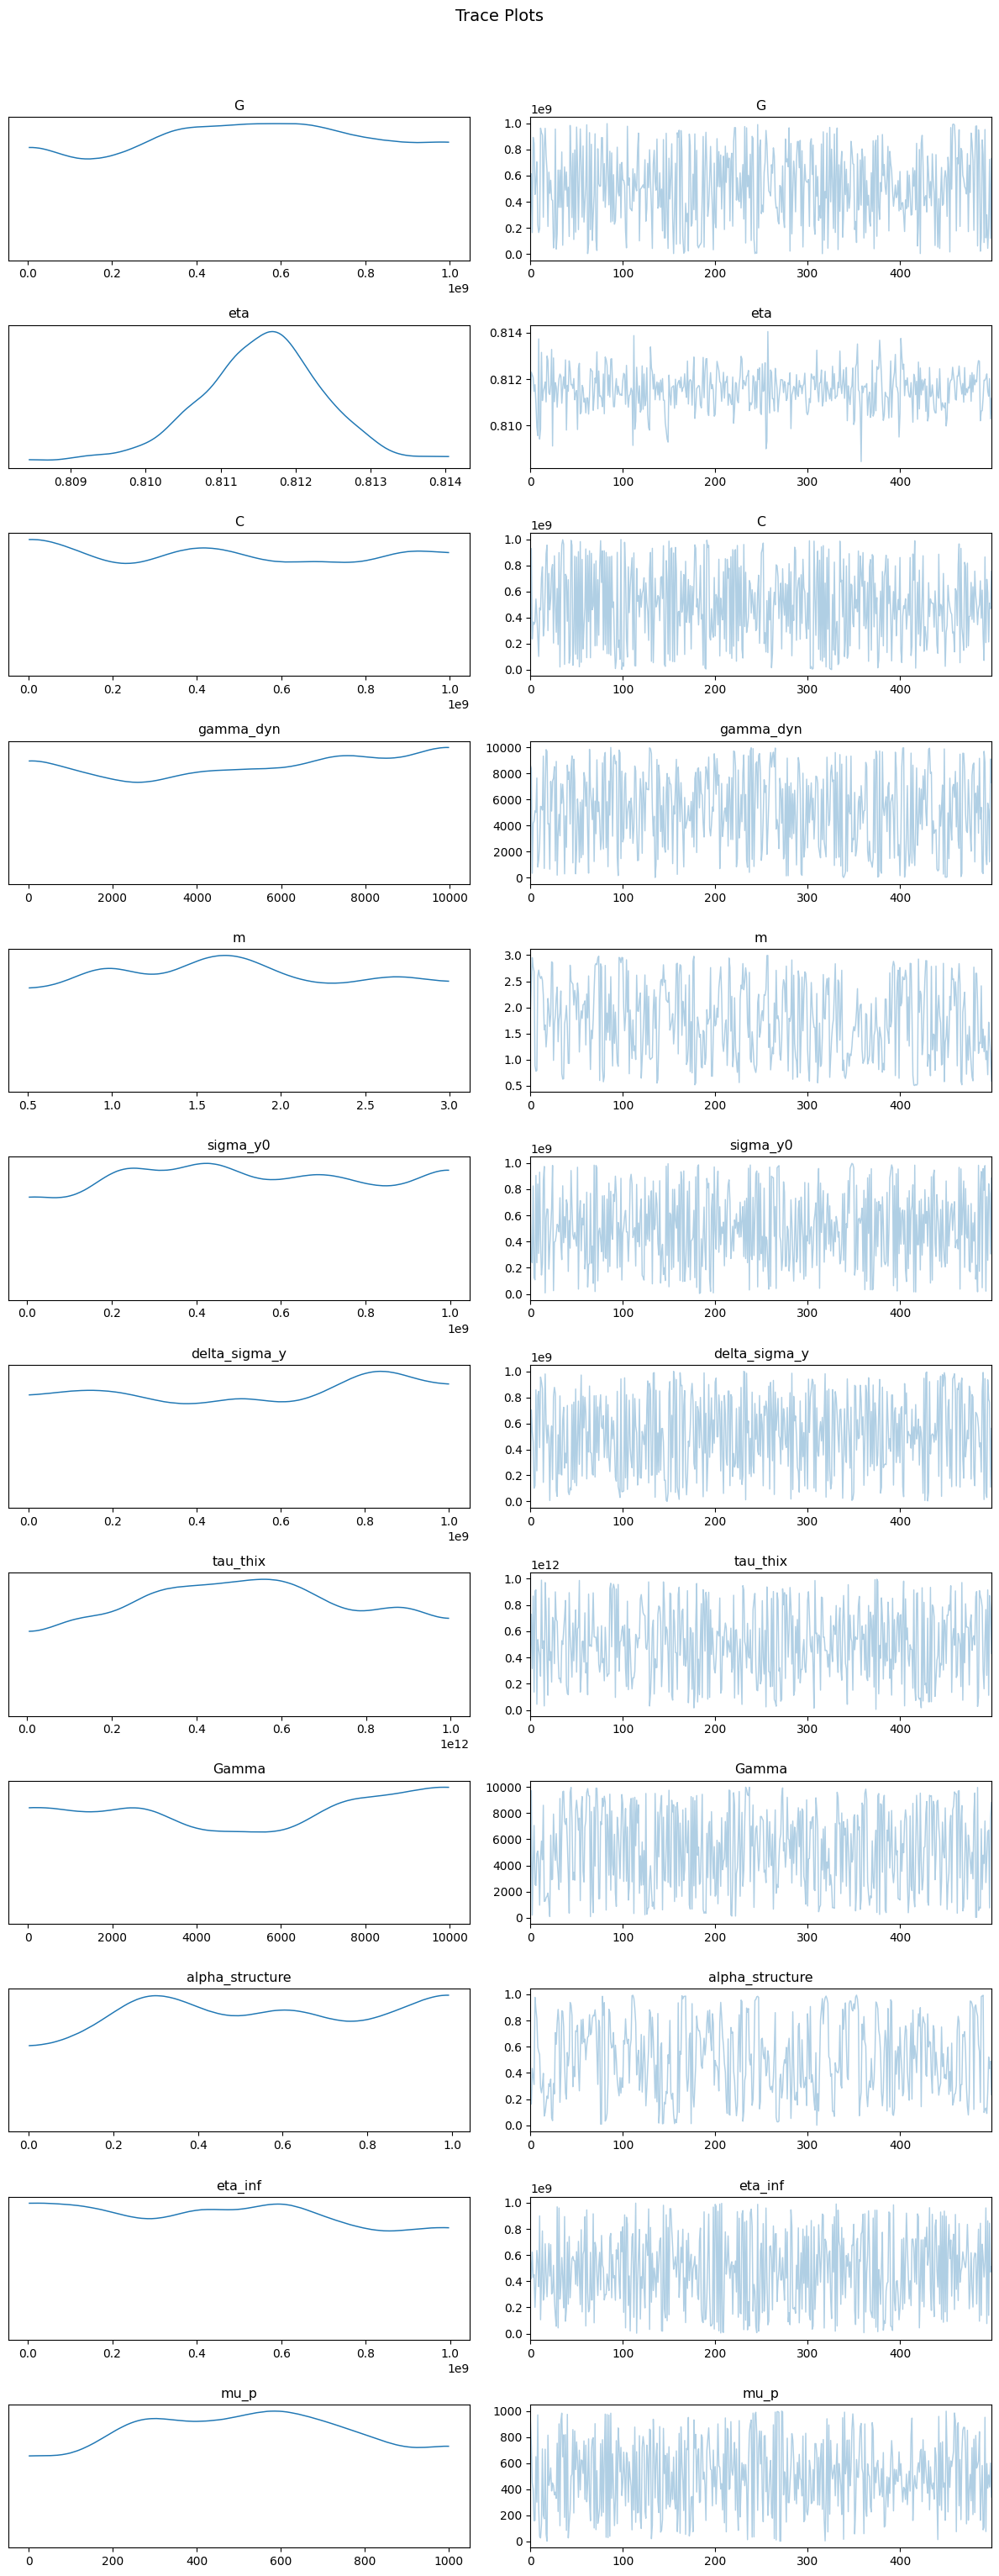

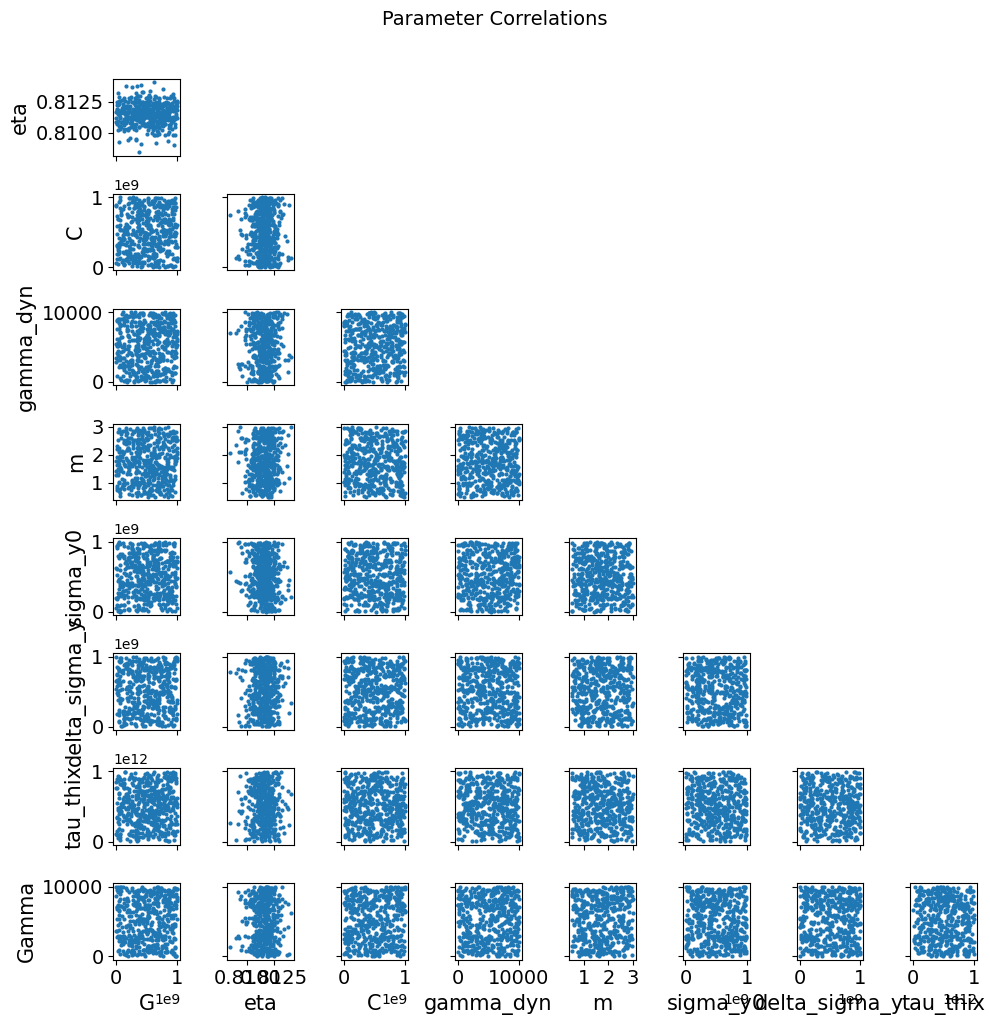

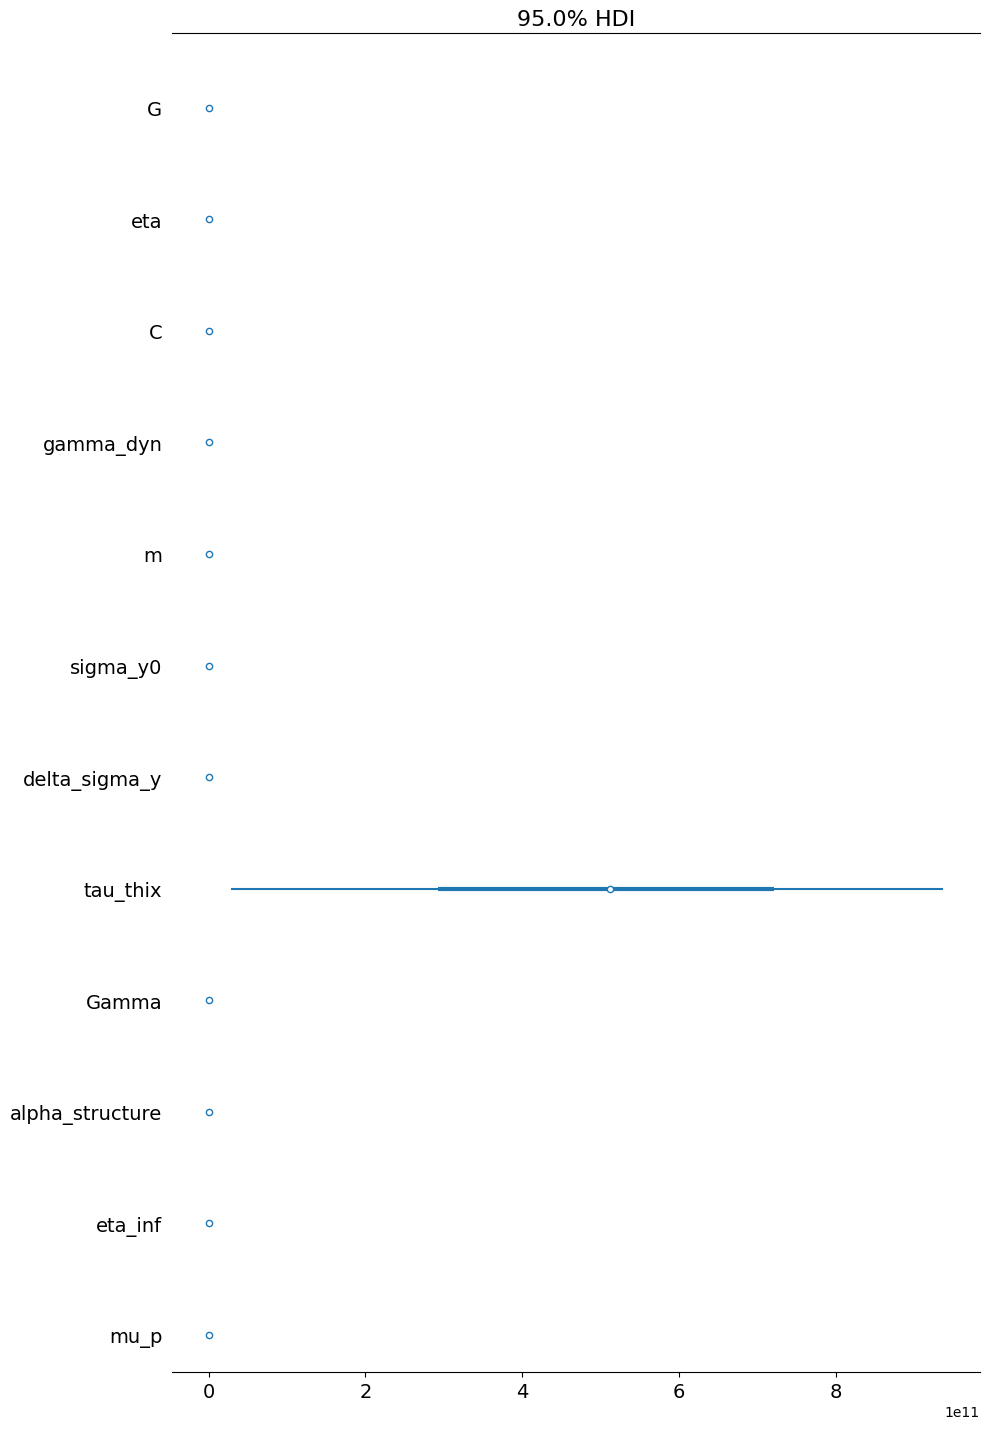

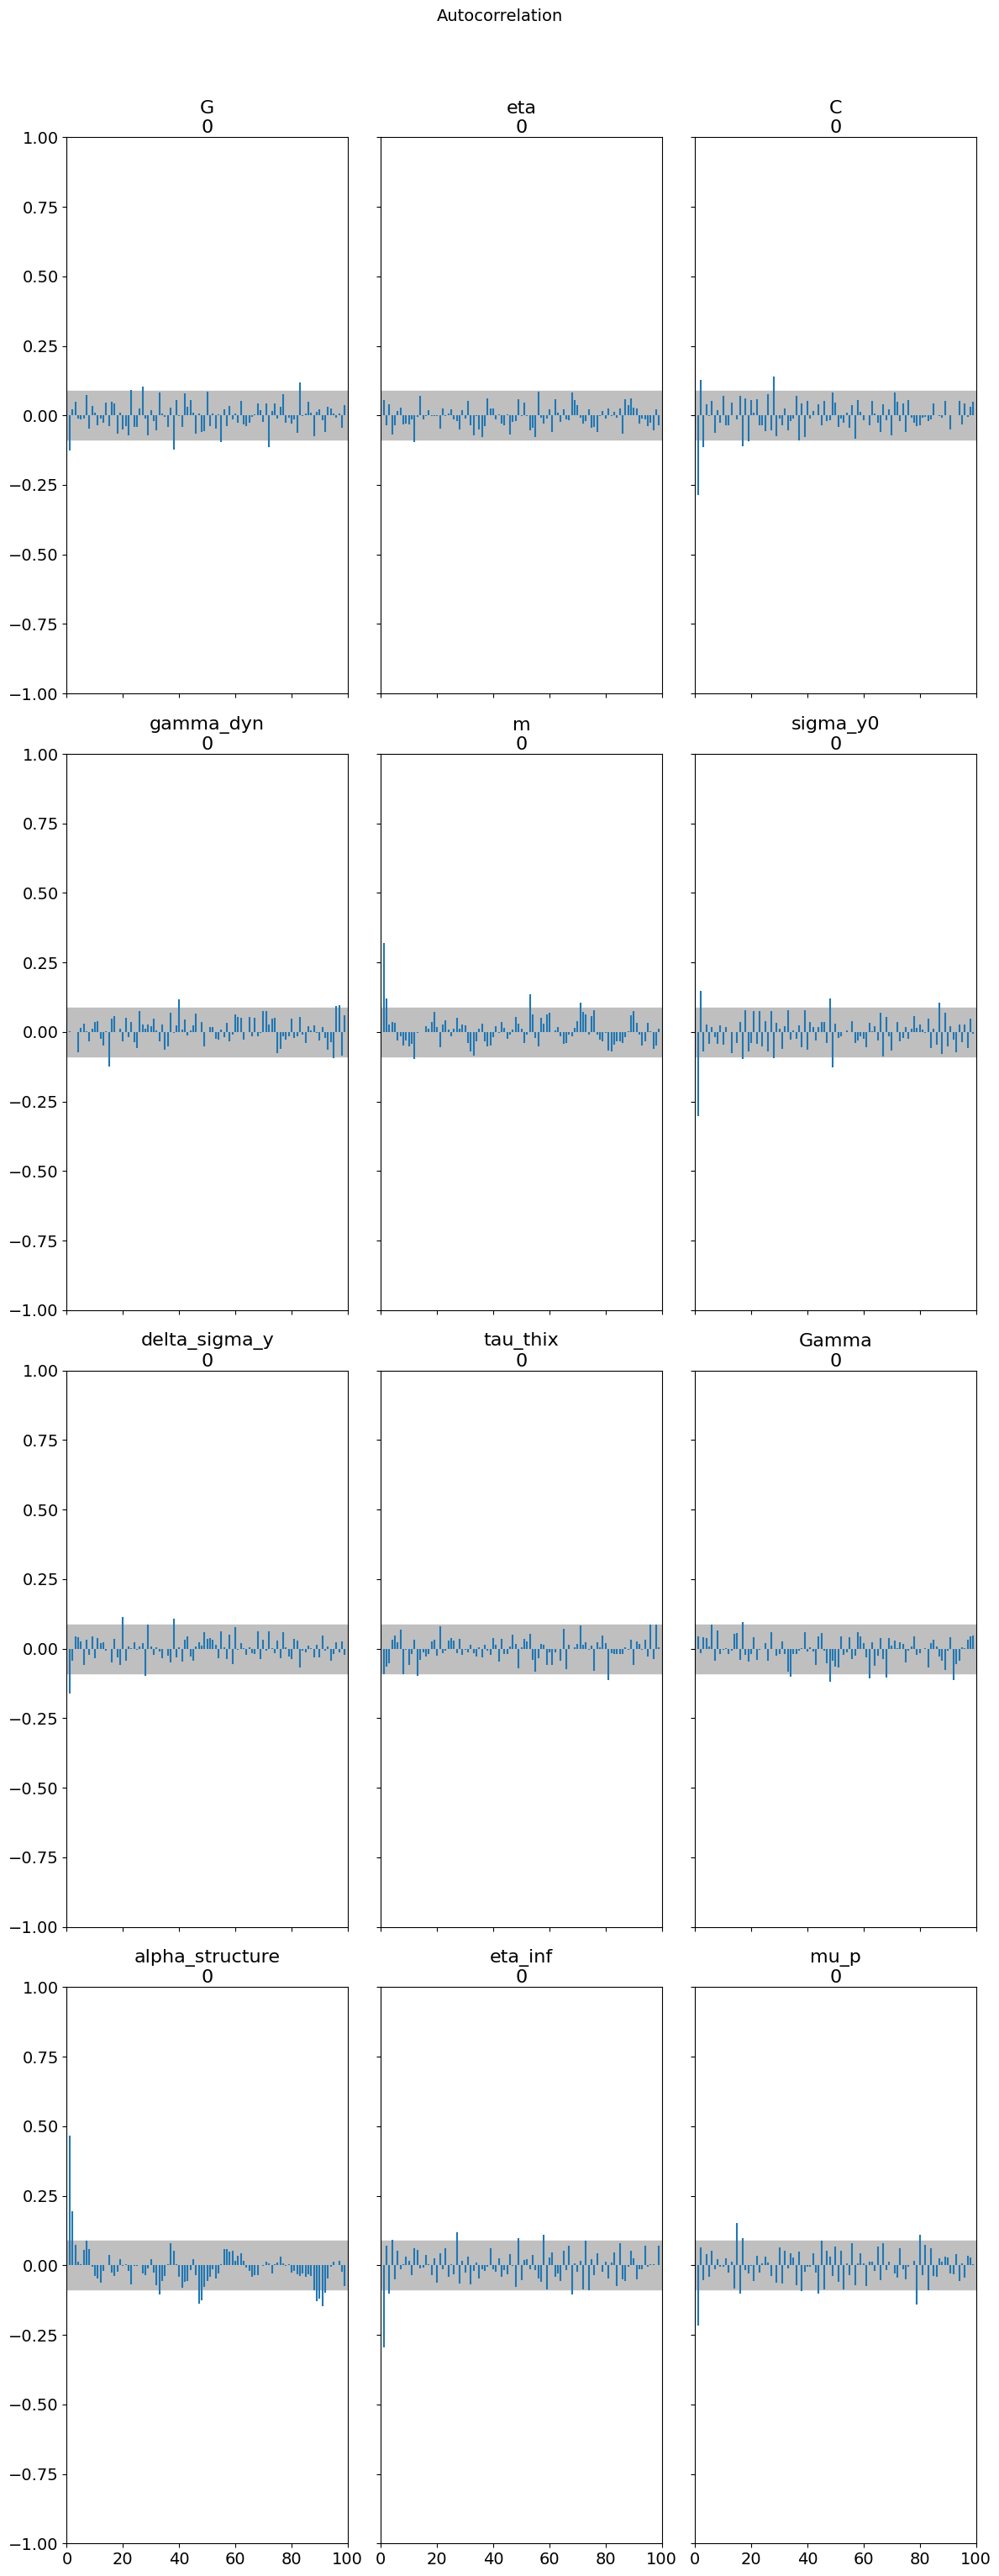

In [11]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorr, rank)
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

In [12]:
# Parameter comparison
posterior = result.posterior_samples
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G          1000     5.177e+08  [2.574e+07, 9.681e+08]
            eta        0.8115        0.8116  [0.8098, 0.813]
              C           500      4.81e+08  [1.745e+07, 9.684e+08]
      gamma_dyn             1          5367  [163.1, 9795]
              m             1         1.717  [0.583, 2.91]
       sigma_y0            10     4.895e+08  [3.155e+07, 9.793e+08]
  delta_sigma_y            50     5.266e+08  [3.017e+07, 9.833e+08]
       tau_thix             1      5.12e+11  [4.876e+10, 9.609e+11]
          Gamma           0.5          5293  [336.9, 9726]
alpha_structure           0.7        0.5094  [0.03272, 0.9809]
        eta_inf           0.1     4.794e+08  [2.245e+07, 9.603e+08]
           mu_p         0.001         513.9  [28.61, 981.3]


## 7. Save Results

In [13]:
save_fikh_results(model, result, "fikh", "creep", param_names)
print("\nResults saved.")

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fikh/creep/
  nlsq_params_creep.json: 12 parameters
  posterior_creep.json: 500 draws

Results saved.


## Key Takeaways

1. **Creep delay time scales as $t_d \sim (\Delta\sigma)^{-1/\alpha}$**
2. **Lower $\alpha$ → exponentially longer delays** for same stress deficit
3. **Viscosity bifurcation**: Delayed yielding followed by avalanche
4. **Fractional memory resists structural breakdown** under constant stress
5. **Creep provides independent constraint on $\alpha$** via transient dynamics
6. **Residual analysis** validates delayed yielding dynamics

---

## Further Reading

- **[FIKH Creep Protocol](../../docs/source/models/fikh/fikh.rst#creep-step-stress)**: Delay time formula and bifurcation analysis
- **[Delayed Yielding](../../docs/source/models/fikh/fikh.rst#viscosity-bifurcation)**: Physical mechanism and industrial implications

### Key References

1. Dimitriou, C.J. & McKinley, G.H. (2014). "A comprehensive constitutive law for waxy crude oil: a thixotropic yield stress fluid." *Soft Matter*, 10, 6619-6644.
2. Geri, M. et al. (2017). "Thermokinematic memory and the thixotropic elasto-viscoplasticity of waxy crude oils." *J. Rheol.*, 61(3), 427-454.

### Next Steps

**Next**: NB05 (SAOS) — Cole-Cole depression and frequency-domain fractional response